In [4]:
# get the current working directory
import os
import sys
from pathlib import Path

cwd = Path.cwd()
output_dir = cwd
model = 'mlp'
dataset = 'california'

# Now import using absolute import
# Add the parent directory to the Python path for absolute imports
sys.path.append(str(cwd.parent))
from utils.load_data import load_rtdl_dataset
from argparse import Namespace

# Create a minimal args object with required attributes
args = Namespace(
    dataset=dataset,
    source="rtdl"
)
X, y = load_rtdl_dataset(args)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)


    Loading dataset california from RTDL library...
    Preparing dataset california...
    Dataset california is already processed. Skipping download and processing.
    Dataset loaded with 8 numerical features and 0 categorical features


In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_intervals_with_boxes(b, w, ax=None):
    if ax is None:
        ax = plt.gca()

    fill_color = to_rgba('blue', alpha=0.3)   # semi-transparent fill
    edge_color = 'blue'                       # fully opaque edge
    
    for i in range(len(b)):
        center = -b[i] / w[i]
        radius = 1 / w[i]
        y = i

        # Rectangle with transparent fill but opaque border
        rect = plt.Rectangle(
            (center - radius, y - 0.4), 2 * radius, 0.8,
            facecolor=fill_color, edgecolor=edge_color, linewidth=0.7
        )
        ax.add_patch(rect)

        # Center vertical line (opaque)
        ax.plot([center, center], [y - 0.4, y + 0.4],
                color='black', linewidth=1)

        # Horizontal stick-out lines (opaque)
        ax.plot([center - 2*radius, center - radius], [y, y],
                color='black', linewidth=0.7)
        ax.plot([center + radius, center + 2*radius], [y, y],
                color='black', linewidth=0.7)
    
    if max(b/w+2/w) > 2 or min(b/w-2/w) < -2:
        ax.set_xlim(-2, 2)  # Restrict x-axis
    else:
        ax.set_xlim(-1, 1)
    #ax.set_yticks(range(len(b)))
    #ax.set_yticklabels([f'{i}' for i in range(len(b))])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel('Value')
    #ax.set_title('Boxes with Opaque Boundaries and Lines')


In [59]:
def draw_conditional_expectation(x, y,ax = None):
    # Define the number of bins
    num_bins = 100

    # Create bins and calculate bin centers
    bins = np.linspace(-1, 1, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate the centroids for each bin
    centroids_x = []
    centroids_y = []

    for i in range(num_bins):
        mask = (x >= bins[i]) & (x < bins[i + 1])
        if np.any(mask):
            centroids_x.append(bin_centers[i])
            centroids_y.append(np.mean(y[mask]))

    if ax is None:
        ax = plt.gca()

    ax.plot(centroids_x, centroids_y, label='E[y|x]', color='blue', linewidth=2)
    ax.set_xlabel('x')
    ax.set_ylabel('y = target variable of California housing')
    #ax.set_title('Conditional Expectation of y given x')
    #ax.legend()
    ax.grid(True)


In [56]:
def draw_derivative_of_conditional_expectation(x, y,ax=None):
    centroids_x = []
    centroids_y = []
    # Define the number of bins
    num_bins = 100
    # Create bins and calculate bin centers
    bins = np.linspace(-1, 1, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Calculate the centroids for each bin
    for i in range(num_bins):
        mask = (x >= bins[i]) & (x < bins[i + 1])
        if np.any(mask):
            centroids_x.append(bin_centers[i])
            centroids_y.append(np.mean(y[mask]))
    

    # also draw the derivative of the curve
    # Calculate the derivative using finite differences
    def calculate_derivative(x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        derivative = dy / dx
        return derivative
    derivative_y = calculate_derivative(np.array(centroids_x), np.array(centroids_y))
    # Calculate the midpoints for the x values
    midpoints_x = (np.array(centroids_x)[:-1] + np.array(centroids_x)[1:]) / 2
    # Plot the derivative

    if ax is None:
        ax = plt.gca()
    
    
    ax.plot(midpoints_x, derivative_y, label='Derivative of Conditional Expectation', color='orange')
    ax.set_xlabel('x')
    ax.set_ylabel('Derivative of y')
    #ax.set_title('Derivative of Conditional Expectation of y given x')
    #ax.legend()
    ax.grid(True)

In [62]:
# def combine_drawings(draw_function_1,x1,y1, draw_function_2, x2, y2, ax = None,title=None):
#     if ax is None:
#         ax = plt.gca()

#     fig = ax.figure
#     # Create secondary axes sharing the same x-axis
#     ax2 = ax.twinx()
    
#     draw_function_1(x1, y1, ax)
#     draw_function_2(x2, y2, ax2)

#     ax.set_xlabel('x = first feature of California housing')
#     ax.set_title(title)
#     fig.legend(loc='upper left', bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes)
def combine_drawings(draw_function_1, x1, y1, draw_function_2, x2, y2, ax=None, title=None):
    if ax is None:
        ax = plt.gca()

    fig = ax.figure
    # Create secondary axes sharing the same x-axis
    ax2 = ax.twinx()

    # Draw the first plot on the primary axis
    draw_function_1(x1, y1, ax)

    # Draw the second plot on the secondary axis
    draw_function_2(x2, y2, ax2)

    # Set labels and title
    ax.set_xlabel('x = first feature of California housing')
    ax.set_title(title)

    # Combine legends from both axes into a single legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes)


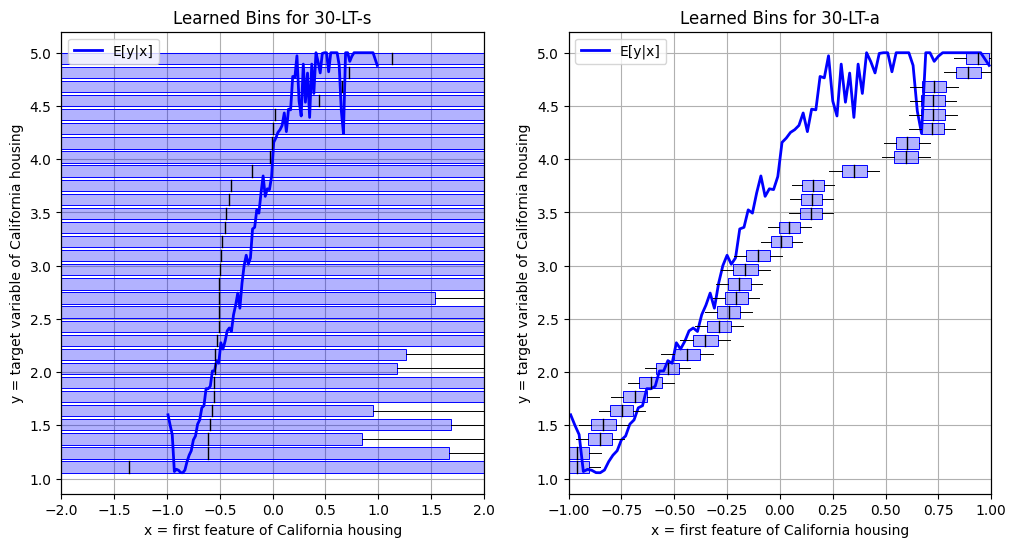

In [63]:

fold_idx = 0
run_names = ['emb_30p_tanh_standard', 'emb_30p_tanh_alpha']
titles = ['30-LT-s', '30-LT-a']

plt.subplots(1,2, figsize=(12, 6))

for i,run_name in enumerate(run_names):
    suffix = "embedding_parameters" if model !=' transformer' else "transformer_parameters"
    path = cwd / output_dir / model / dataset / run_name / suffix

    # Add the project root directory to Python path
    project_root = Path.cwd().parent  # Adjust this if your notebook is in a different location
    sys.path.append(str(project_root))
    
    
    B = np.load(path / f'b_{fold_idx}.npy')
    W = np.load(path / f'W_{fold_idx}.npy')

    feat_idx = 0
    x = X[:, feat_idx]
    b = B[feat_idx]
    w = W[feat_idx]
    # sort the weights and biases together based on the bias
    sorted_indices = np.argsort(-b/w)
    b = b[sorted_indices]
    w = w[sorted_indices]

    ax = plt.subplot(1,2,i+1)
    combine_drawings(draw_conditional_expectation, x, y,
                 plot_intervals_with_boxes, b, w,
                 ax=ax,
                 title=f'Learned Bins for {titles[i]}')